This notebook produces the plots for the Supplementary Material of the photon noise paper.

In [1]:
import pandas as pd
from kid_readout.analysis import archive, dataframe, plot_dataframe

updated file list


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
bb = pd.DataFrame(np.load('broadband.npy'))
cw = pd.DataFrame(np.load('continuous-wave.npy'))
off = pd.DataFrame(np.load('compressor_off.npy')).iloc[0]  # off is a pd.Series

In [3]:
#cw_file_max = 'cw20_ampfreebincut10prop'
#cw_file_short = 'afbc10p'

In [4]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_short = 'afbc10p'
off_max_name = 'dark_ampfree_alphafix_bincut10prop'
off_max_short = 'afaxbc10p'

In [22]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()

    
def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
    else:
        unit = 'pW'
        scale = 1
    scaled = 1e12 * scale * f
    precision = 2 - int(np.floor(np.log10(scaled)))
    format_string = '{{:.{}f}} {{}}'.format(precision)
    return format_string.format(scaled, unit)


def white_noise_model(f, series):
    W2 = series.noise_fit_device_noise
    A2 = series.noise_fit_amplifier_noise
    f_c = series.noise_fit_fc
    return W2 / (1 + (f / f_c)**2) + A2


def pink_noise_model(f, series, key):
    W2 = series['{}_white'.format(key)]
    A2 = series['{}_amp'.format(key)]
    f_c = series['{}_invtau'.format(key)]
    f_k = series['{}_fknee'.format(key)]
    alpha = series['{}_alpha'.format(key)]
    return W2 * (1 + (f / f_k)**(-alpha)) / (1 + (f / f_c)**2) + A2

# Plotting

In [6]:
noise_colormap = plt.cm.RdYlBu_r
cw_color = 'saddlebrown'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"  # "c-w {:.0f} GHz".format(1e-9 * cw.timestream_mmw_source_freq.iloc[0])
bb_label = "broadband"  # "bb 140-160 GHz"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 1e-19, Sx_scale * 3e-15)
noise_xlimits = (1e1, 1e4)

#PA_scale = 1e12
#X_scale = 1e6
#PA_limits = (8e-4, 6e1)
#X_limits = (1e-1, 1e3)
#NEPA_limits = (1e-18, 1e-15)
#PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
#to_aWrtHz = 1e18
ff = np.logspace(0, 4, 1e3)

In [7]:
mappable_cw = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(cw.source_power), max(cw.source_power)),
                                    cmap=noise_colormap)
mappable_cw.set_array(cw.source_power)

mappable_bb = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(bb.source_power), max(bb.source_power)),
                                    cmap=noise_colormap)
mappable_bb.set_array(bb.source_power)

In [8]:
dark_color = 'black'

In [9]:
single_channel = common(bb, 'channel')

Calculate the TLS noise contribution using the dark data.

In [10]:
# Extract the dark parameters for convenience
white = off['{}_white'.format(off_max_name)]
alpha = off['{}_alpha'.format(off_max_name)]
amp = off['{}_amp'.format(off_max_name)]
f_c = off['{}_invtau'.format(off_max_name)]
f_k = off['{}_fknee'.format(off_max_name)]

A_TLS = white * (f_k / 1)**alpha
S_TLS = (A_TLS * ff**(-alpha) /
         (1 + (ff / f_c)**2))

In [11]:
cw['A_TLS'] = A_TLS * (cw.readout_power_internal / off.readout_power_internal)**(-1/2)
cw_minimum_power = cw[cw.source_power == cw.source_power.min()].iloc[0]
cw_maximum_power = cw[cw.source_power == cw.source_power.max()].iloc[0]

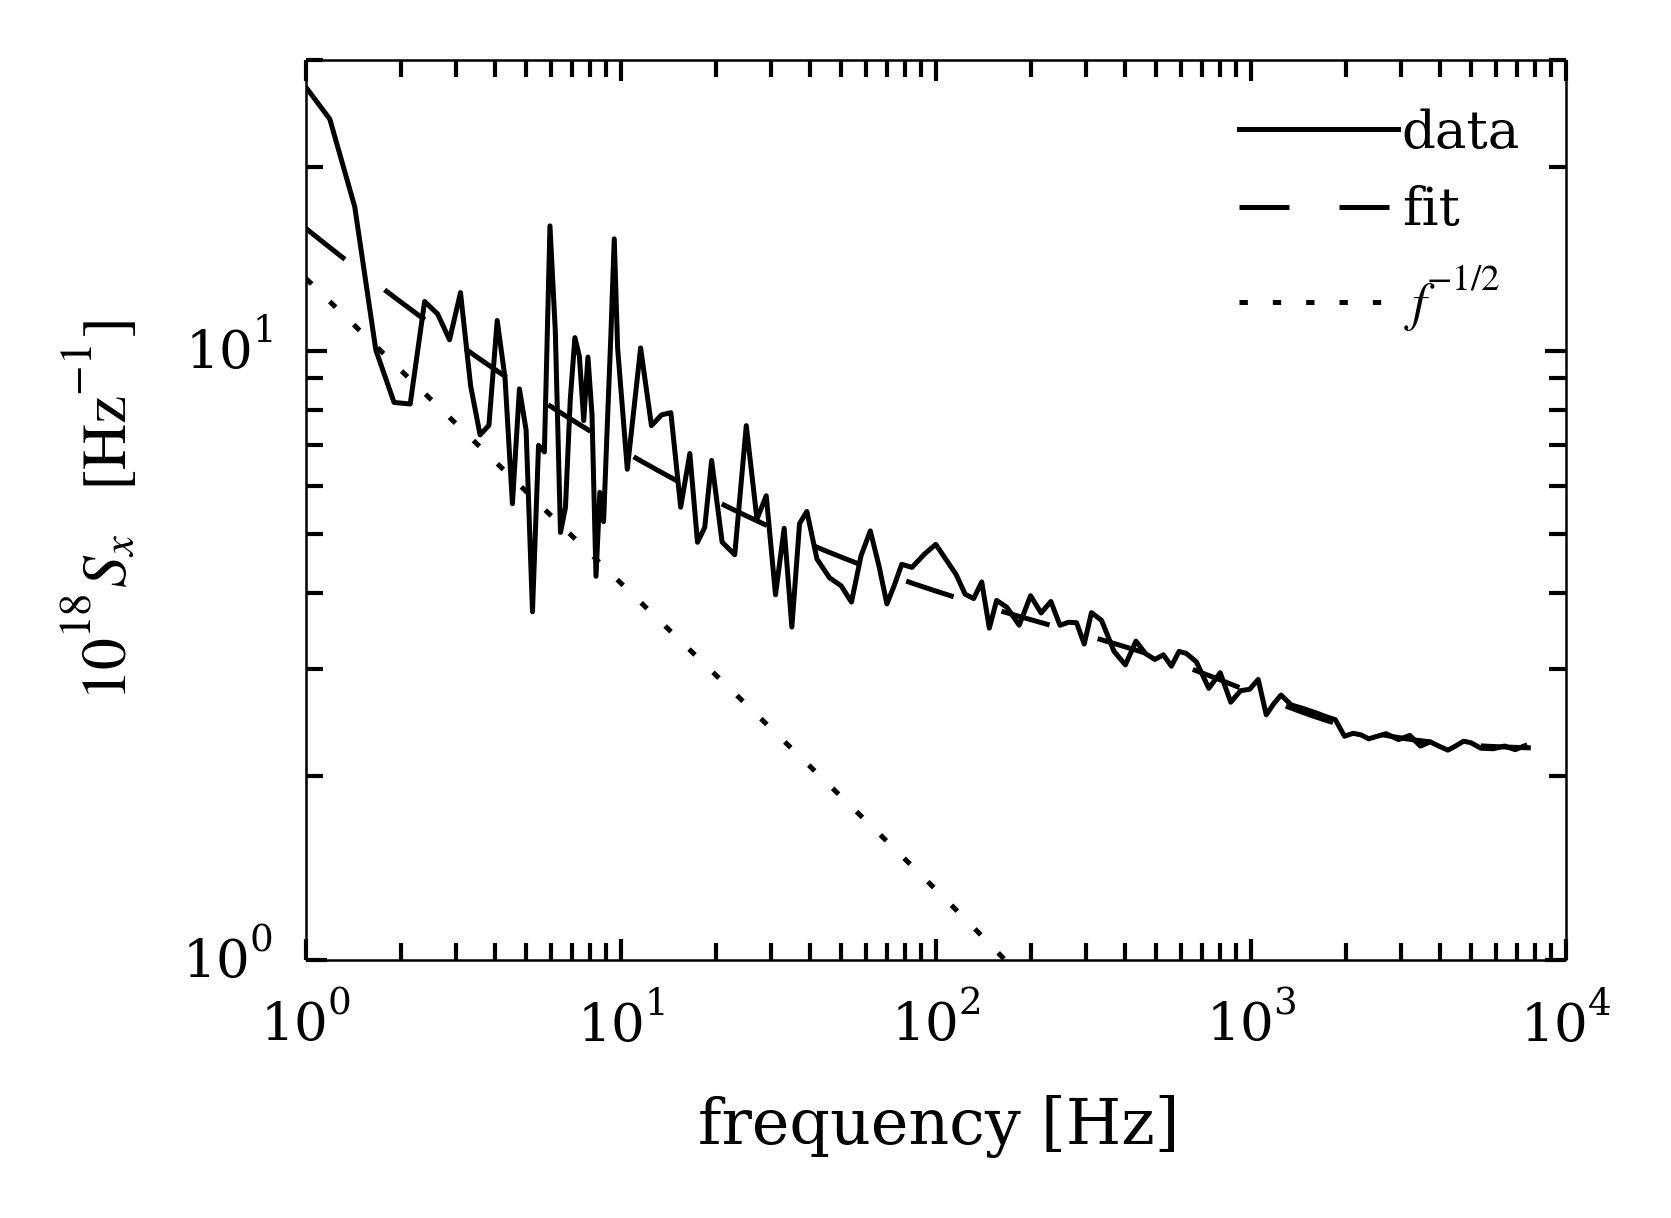

In [12]:
fig, ax = plt.subplots()

ax.loglog(off.pca_freq,
          Sx_scale * off.pca_eigvals[1],
          '-k', label='data')

ax.loglog(ff,
          Sx_scale * pink_noise_model(ff, off, off_max_name),
          '--k', label='fit')

ax.loglog(ff,
          Sx_scale * S_TLS,
          ':k', label='$f^{-1/2}$')

ax.set_ylabel('$10^{18} S_x \; [\mathrm{Hz}^{-1}]$')
ax.set_xlabel('frequency [Hz]')
ax.legend(loc='upper right')
ax.set_xlim(1e0, 1e4)
ax.set_ylim(1, 30)

fig.savefig('dark_noise.pdf')
fig.savefig('dark_noise.eps')

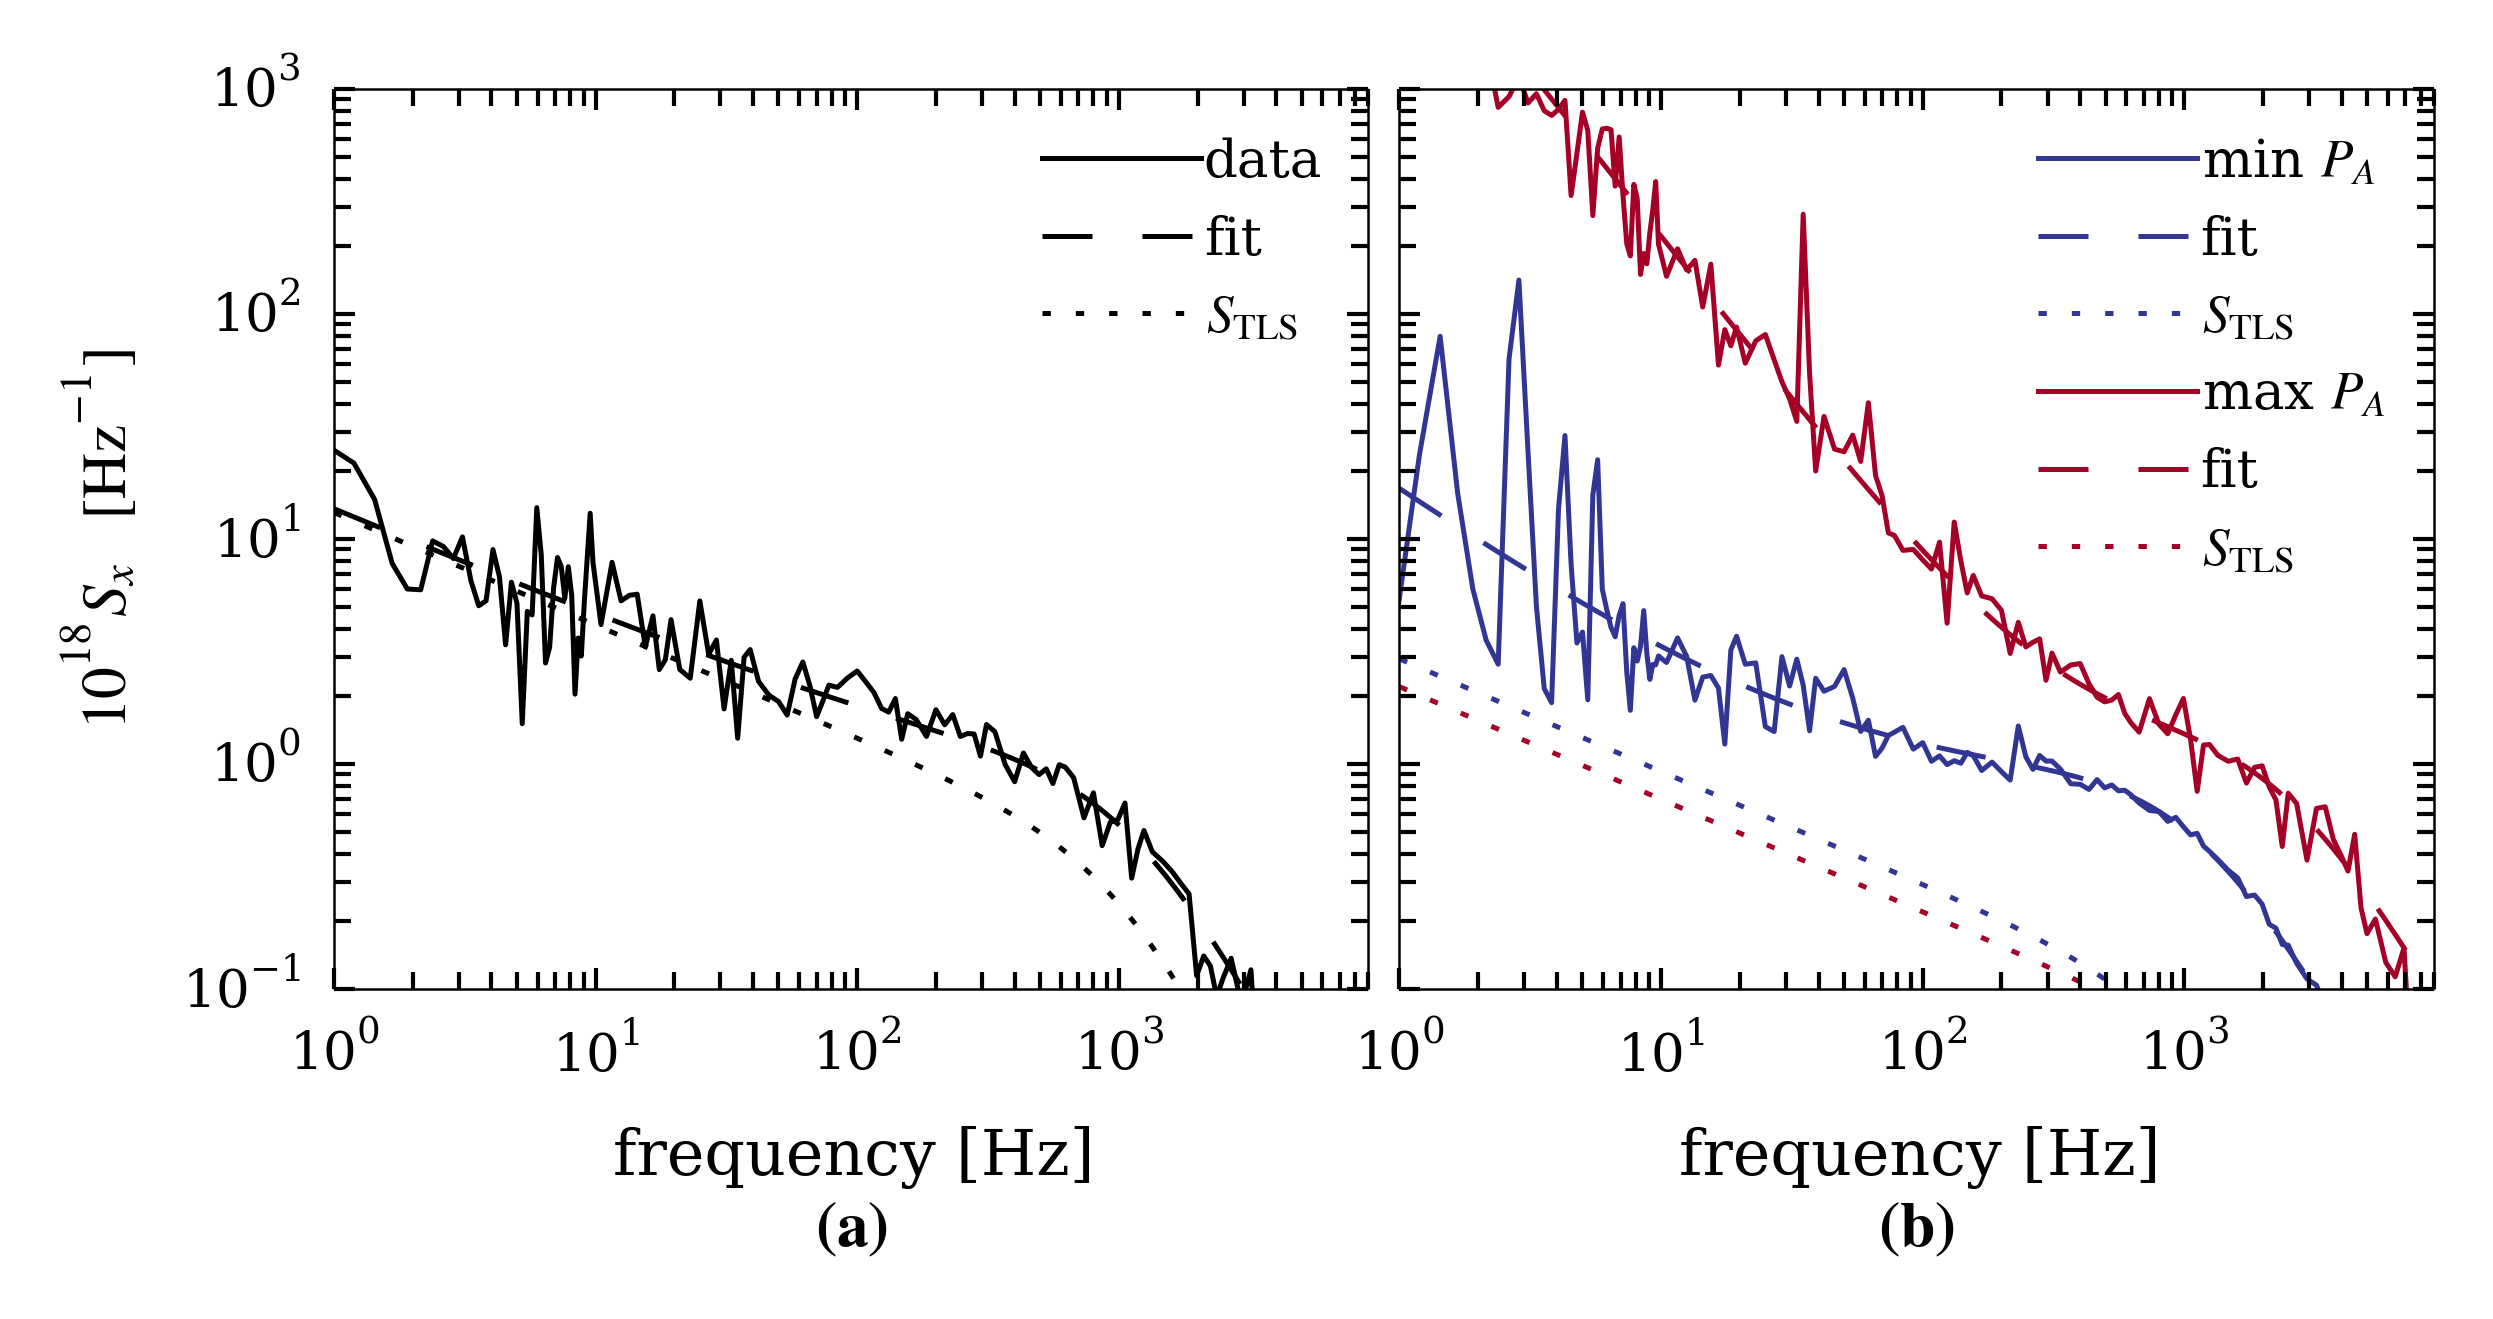

In [19]:
xlimits = (1e0, 0.9e4)
ylimits = (1e-1, 1e3)

with plt.rc_context({'figure.subplot.wspace': 0.03}):
    fig, (dark_ax, light_ax)  = plt.subplots(ncols=2, figsize=(5, 2))
    
    # Plot dark data
    dark_ax.loglog(off.pca_freq,
                   Sx_scale * (off.pca_eigvals[1] - amp),
                   '-', color=dark_color, label='data')

    dark_ax.loglog(ff,
                   Sx_scale * (pink_noise_model(ff, off, off_max_name) - amp),
                   '--k', color=dark_color, label='fit')

    dark_ax.loglog(ff,
                   Sx_scale * S_TLS,
                   ':', color=dark_color, label='$S_\mathrm{TLS}$')


    # Plot light minimum power data
    light_ax.loglog(cw_minimum_power.pca_freq,
                    Sx_scale * (cw_minimum_power.pca_eigvals[1] -
                                cw_minimum_power['{}_amp'.format(cw_max_name)]),
                    '-', color=mappable_cw.to_rgba(cw_minimum_power.source_power),
                    label='min $P_A$')
    
    light_ax.loglog(ff,
                   Sx_scale * (pink_noise_model(ff, cw_minimum_power, cw_max_name) -
                               cw_minimum_power['{}_amp'.format(cw_max_name)]),
                   '--k', color=mappable_cw.to_rgba(cw_minimum_power.source_power),
                    label='fit')

    light_ax.loglog(ff,
                    Sx_scale * (cw_minimum_power.A_TLS * ff**(-1/2) /
                                (1 + (ff / cw_minimum_power['{}_invtau'.format(cw_max_name)])**2)),
                    ':', color=mappable_cw.to_rgba(cw_minimum_power.source_power),
                    label='$S_\mathrm{TLS}$')

    # Plot light maximum power data
    light_ax.loglog(cw_maximum_power.pca_freq,
                    Sx_scale * (cw_maximum_power.pca_eigvals[1] -
                                cw_maximum_power['{}_amp'.format(cw_max_name)]),
                    '-', color=mappable_cw.to_rgba(cw_maximum_power.source_power),
                    label='max $P_A$')
    
    light_ax.loglog(ff,
                    Sx_scale * (pink_noise_model(ff, cw_maximum_power, cw_max_name) -
                               cw_maximum_power['{}_amp'.format(cw_max_name)]),
                   '--k', color=mappable_cw.to_rgba(cw_maximum_power.source_power),
                    label='fit')

    light_ax.loglog(ff,
                    Sx_scale * (cw_maximum_power.A_TLS * ff**(-1/2) /
                                (1 + (ff / cw_maximum_power['{}_invtau'.format(cw_max_name)])**2)),
                    ':', color=mappable_cw.to_rgba(cw_maximum_power.source_power),
                    label='$S_\mathrm{TLS}$')
  

    dark_ax.set_ylabel('$10^{18} S_x \; [\mathrm{Hz}^{-1}]$')
    dark_ax.set_xlabel('frequency [Hz]\n'  + r'${\bf(a)}$')
    dark_ax.legend(loc='upper right')
    dark_ax.set_xlim(*xlimits)
    dark_ax.set_ylim(*ylimits)

    light_ax.set_xlabel('frequency [Hz]\n'  + r'${\bf(b)}$')
    light_ax.legend(loc='upper right', fontsize='xx-small')
    light_ax.set_xlim(*xlimits)
    light_ax.set_ylim(*ylimits)
    light_ax.set_yticklabels([]);

fig.savefig('dark_and_light_noise_minus_amp_two_panel.pdf')
fig.savefig('dark_and_light_noise_minus_amp_two_panel.eps')

xlimits = (1e0, 0.9e4)
ylimits = (1e-1, 1e3)

with plt.rc_context({'figure.subplot.wspace': 0.03}):
    fig, (dark_ax, light_ax)  = plt.subplots(ncols=2, figsize=(5, 2))
    
    # Plot dark data
    dark_ax.loglog(off.pca_freq,
                   Sx_scale * off.pca_eigvals[1],
                   '-', color=dark_color, label='data')

    dark_ax.loglog(ff,
                   Sx_scale * ((A_device * off.noise_fit_device_noise /
                                (1 + (ff / off.noise_fit_fc)**2)) +
                               off.noise_fit_amplifier_noise +
                               S_TLS),
                   '--', color=dark_color, label='fit')
    
    dark_ax.loglog(ff,
                   Sx_scale * S_TLS,
                   ':', color=dark_color, label='$S_\mathrm{TLS}$')


    # Plot light data
    light_ax.loglog(cw_minimum_power_row.pca_freq,
                    Sx_scale * cw_minimum_power_row.pca_eigvals[1],
                    '-', color=mappable_cw.to_rgba(cw_minimum_power_row.source_power),
                    label='min $P_A$')

    light_ax.loglog(ff,
                    Sx_scale * (cw_minimum_power_row.A_TLS * ff**(-1/2) /
                                (1 + (ff / cw_minimum_power_row.noise_fit_fc)**2)),
                    ':', color=mappable_cw.to_rgba(cw_minimum_power_row.source_power),
                    label='scaled $S_\mathrm{TLS}$')

    light_ax.loglog(cw_maximum_power_row.pca_freq,
                    Sx_scale * cw_maximum_power_row.pca_eigvals[1],
                    '-', color=mappable_cw.to_rgba(cw_maximum_power_row.source_power),
                    label='max $P_A$')

    light_ax.loglog(ff,
                    Sx_scale * (cw_maximum_power_row.A_TLS * ff**(-1/2) /
                                (1 + (ff / cw_maximum_power_row.noise_fit_fc)**2)),
                    ':', color=mappable_cw.to_rgba(cw_maximum_power_row.source_power),
                    label='scaled $S_\mathrm{TLS}$')
    
dark_ax.set_ylabel('$10^{18} S_x \; [\mathrm{Hz}^{-1}]$')
dark_ax.set_xlabel('frequency [Hz]\n'  + r'${\bf(a)}$')
dark_ax.legend(loc='upper right')
dark_ax.set_xlim(*xlimits)
dark_ax.set_ylim(*ylimits)

light_ax.set_xlabel('frequency [Hz]\n'  + r'${\bf(b)}$')
light_ax.legend(loc='upper right', fontsize='xx-small')
light_ax.set_xlim(*xlimits)
light_ax.set_ylim(*ylimits)
light_ax.set_yticklabels([]);

fig.savefig('dark_and_light_noise_two_panel.pdf')
fig.savefig('dark_and_light_noise_two_panel.eps')

# Tables

In [ ]:
data = h5py.File('bb21_ampfreebincut10prop.h5', 'r')
datalist = []
for spec in data.keys():
    params = {}
        params['num'] = str(spec)
        for key in data[spec].keys():
            params[str(key)] = data[spec][key][()]
        datalist.append(params)
        row = params['num']+" & "+str(round(params['white']*1e18,3))+" $\pm$ "+\
              str(round(params['white_std']*1e18,3))+" & "
        row += str(int(params['fknee']))+" $\pm$ "+\
               str(int(params['fknee_std']))+" & "
        row += str(int(params['invtau']))+" $\pm$ "+\
               str(int(params['invtau_std']))+" & "
        row += str(round(params['alpha'], 2))+" $\pm$ "+\
               str(round(params['alpha_std'], 2))+" & "
        row += str(round(params['amp']*1e18, 3))+" $\pm$ "+\
               str(round(params['amp_std']*1e18, 3))+" \\\ \hline"
        print row

In [56]:
eta_bb = common(bb, 'eta')
eta_cw = common(cw, 'eta')

params = ('amp', 'white', 'fknee', 'alpha', 'invtau')
scales = (1e18, 1e18, 1, 1, 1)
values = (3, 3, 0, 3, -1)
errors = (3, 2, 0, 1, 0)

def make_table(df, name, eta):
    lines = []
    for index, row in df.iterrows():
        s = [float_to_latex(eta * row.source_power)]
        for param, scale, value, error in zip(params, scales, values, errors):
            s.append('{} $\pm$ {}'.format(round(scale * row['{}_{}'.format(name, param)], value),
                                        round(scale * row['{}_{}_std'.format(name, param)], error)))
        lines.append(' & '.join(s) + r' \\')
    return lines
    """
    row = params['num']+" & "+str(round(params['white']*1e18,3))+" $\pm$ "+\
              str(round(params['white_std']*1e18,3))+" & "
        row += str(int(params['fknee']))+" $\pm$ "+\
               str(int(params['fknee_std']))+" & "
        row += str(int(params['invtau']))+" $\pm$ "+\
               str(int(params['invtau_std']))+" & "
        row += str(round(params['alpha'], 2))+" $\pm$ "+\
               str(round(params['alpha_std'], 2))+" & "
        row += str(round(params['amp']*1e18, 3))+" $\pm$ "+\
               str(round(params['amp_std']*1e18, 3))+" \\\ \hline"
        print row
        """

In [57]:
for line in make_table(cw, cw_max_name, eta_cw):
    print(line)

29.0 pW & 4.89 $\pm$ 0.062 & 1.32 $\pm$ 0.12 & 332.0 $\pm$ 44.0 & 1.462 $\pm$ 0.1 & 2480.0 $\pm$ 387.0 \\
18.1 pW & 3.2 $\pm$ 0.042 & 1.463 $\pm$ 0.09 & 269.0 $\pm$ 31.0 & 1.331 $\pm$ 0.1 & 2560.0 $\pm$ 252.0 \\
9.72 pW & 1.821 $\pm$ 0.027 & 1.266 $\pm$ 0.07 & 222.0 $\pm$ 27.0 & 1.282 $\pm$ 0.1 & 2450.0 $\pm$ 199.0 \\
4.89 pW & 0.984 $\pm$ 0.012 & 1.222 $\pm$ 0.05 & 160.0 $\pm$ 15.0 & 1.247 $\pm$ 0.1 & 2170.0 $\pm$ 105.0 \\
1.93 pW & 0.462 $\pm$ 0.006 & 0.966 $\pm$ 0.04 & 98.0 $\pm$ 12.0 & 1.09 $\pm$ 0.1 & 1830.0 $\pm$ 73.0 \\
573 fW & 0.288 $\pm$ 0.003 & 0.87 $\pm$ 0.04 & 52.0 $\pm$ 7.0 & 1.061 $\pm$ 0.1 & 1560.0 $\pm$ 55.0 \\
176 fW & 0.244 $\pm$ 0.003 & 0.883 $\pm$ 0.06 & 37.0 $\pm$ 8.0 & 0.855 $\pm$ 0.2 & 1290.0 $\pm$ 55.0 \\
48.7 fW & 0.219 $\pm$ 0.002 & 0.818 $\pm$ 0.05 & 39.0 $\pm$ 7.0 & 0.978 $\pm$ 0.1 & 1210.0 $\pm$ 46.0 \\
13.0 fW & 0.21 $\pm$ 0.002 & 0.749 $\pm$ 0.17 & 40.0 $\pm$ 35.0 & 0.557 $\pm$ 0.2 & 1170.0 $\pm$ 84.0 \\
2.09 fW & 0.235 $\pm$ 0.002 & 0.85 $\pm$ 0.08 & 38

In [58]:
for line in make_table(bb, bb_max_name, eta_bb):
    print(line)

30.4 pW & 5.157 $\pm$ 0.141 & 9.974 $\pm$ 0.2 & 2.0 $\pm$ 16.0 & 1.351 $\pm$ 5.9 & 2960.0 $\pm$ 120.0 \\
22.1 pW & 3.879 $\pm$ 0.101 & 7.657 $\pm$ 0.14 & 11.0 $\pm$ 3.0 & 1.887 $\pm$ 0.9 & 2890.0 $\pm$ 106.0 \\
13.5 pW & 2.668 $\pm$ 0.06 & 5.289 $\pm$ 0.14 & 7.0 $\pm$ 4.0 & 1.03 $\pm$ 0.5 & 2720.0 $\pm$ 109.0 \\
7.76 pW & 1.381 $\pm$ 0.031 & 3.81 $\pm$ 0.08 & 12.0 $\pm$ 3.0 & 1.203 $\pm$ 0.4 & 2480.0 $\pm$ 81.0 \\
3.88 pW & 0.816 $\pm$ 0.019 & 2.43 $\pm$ 0.13 & 9.0 $\pm$ 4.0 & 0.771 $\pm$ 0.3 & 2340.0 $\pm$ 99.0 \\
1.49 pW & 0.481 $\pm$ 0.007 & 1.729 $\pm$ 0.05 & 14.0 $\pm$ 3.0 & 1.202 $\pm$ 0.3 & 1800.0 $\pm$ 52.0 \\
556 fW & 0.309 $\pm$ 0.005 & 1.109 $\pm$ 0.04 & 13.0 $\pm$ 3.0 & 1.043 $\pm$ 0.3 & 1700.0 $\pm$ 60.0 \\
147 fW & 0.229 $\pm$ 0.002 & 0.975 $\pm$ 0.03 & 21.0 $\pm$ 2.0 & 1.247 $\pm$ 0.2 & 1290.0 $\pm$ 34.0 \\
37.6 fW & 0.201 $\pm$ 0.002 & 0.695 $\pm$ 0.09 & 56.0 $\pm$ 24.0 & 0.702 $\pm$ 0.1 & 1240.0 $\pm$ 67.0 \\
8.42 fW & 0.247 $\pm$ 0.002 & 0.769 $\pm$ 0.08 & 57.0 $\pm$ 